In [1]:
import ma_codes as codes
from ma_codes import mysize, mymap, gray_red

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb

## Some Plotting Parameters
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({'font.size': 14})
plt.rcParams['pdf.fonttype'] = 42
sb.set_style("ticks")
rocket = sb.color_palette("rocket", as_cmap = True)

#pd.set_option("display.max_columns", 100)

#import diffxpy.api as de
#print(de.__version__)  ## before: v0.7.4

import diffxpy.api as de
print(de.__version__)  ## before: v0.7.4
sc.logging.print_version_and_date()

2024-09-04 12:57:08.747377: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 12:57:08.750157: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 12:57:08.756912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1725447428.767360 2047049 cuda_dnn.cc:8430] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1725447428.770533 2047049 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 12:57:08.779491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

v0.7.4
Running Scanpy 1.10.2, on 2024-09-04 12:57.


In [2]:
import sparse
sparse.__version__

'0.9.1'

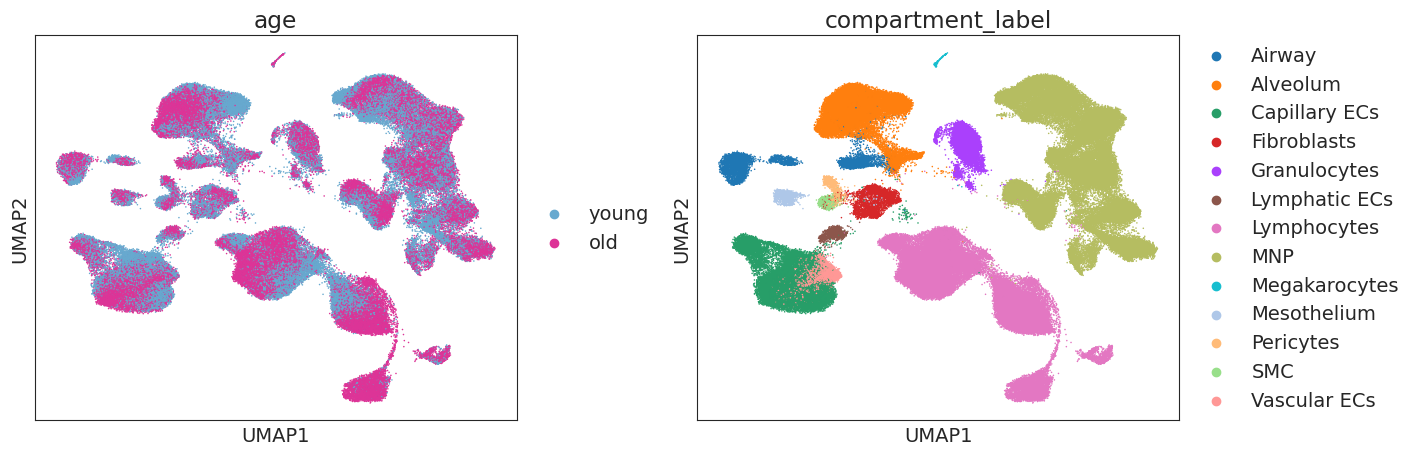

In [3]:
object_folder = "/media/HDD_1/Janine/Aging_SingleCell/data_objects/"
adata = sc.read(object_folder + "230111_Bleo_Ageing_annotated_final.h5ad", cache = False)
sc.pl.umap(adata, color = ["age", "compartment_label"], size = 5, wspace = 0.25)

In [4]:
adata

AnnData object with n_obs × n_vars = 160477 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'name_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connect

In [5]:
### Scaling of counts is recommended for diffxpy
adata.obs["n_counts_scaled"] = adata.obs["n_counts"] / adata.obs["n_counts"].mean()

In [16]:
days = ["d37","d0", "d3", "d10", "d20", "d30"]

### Write it into function finally

In [17]:
def dge(a, ct = "d0", ct_label = "day", condition = "age", ref = "young", 
        pct_thresh = 0.05, subset = ["young", "old"], min_cells = 10, do_return = None, 
        suffix = "", myofib = None):
    
    if myofib:
        cells = a.obs.loc[:, ct_label].isin(subset)
    else:
        cells = a.obs.loc[:, ct_label] == ct
    
    count = a[cells].obs.loc[:, condition].value_counts()
    if (len(count) < 2) or (count[0] < min_cells) or (count[1] < min_cells):
        print("Too few cells in one condition (%s)\n%s" %(ct, count))
        return
        
    ## As threshold, take 5% of all cells in cell type per group
    tab = pd.DataFrame(index = a.var_names)
    tab = codes.add_pct(a[cells], tab = tab, group_by = condition,
                        gene_label = "index", ids = subset)
    test_genes = tab[(tab.loc[:, "pct.%s" %subset[0]] > pct_thresh) | (tab.loc[:, "pct.%s" %subset[1]] > pct_thresh)].index

    if myofib:
        print("Running Myofibroblast Version")
        adata_raw = codes.generate_count_object(a[:, test_genes], condition = condition,
                                                cell_type_label = ct_label, cell_type = subset, 
                                                ref = ref, min_cells = 5, subset = subset)
    
    else:
        adata_raw = codes.generate_count_object(a[:, test_genes], condition = condition, 
                                                cell_type_label = ct_label, cell_type = [ct], 
                                                ref = ref, min_cells = 5, subset = subset)

    print("Started Diffxpy Calculation:\t%s" %codes.timestamp())

    de_test = de.test.wald(data = adata_raw.X, formula_loc = "~ 1 + %s" %condition,
                           factor_loc_totest = condition,
                           training_strategy = [{"max_steps": 100, "update_b_freq": 5,
                                                "ftol_b": 1e-8, "max_iter_b": 100}],
                           gene_names = adata_raw.var_names, sample_description = adata_raw.obs,
                           noise_model = "nb", size_factors = "n_counts_scaled")

    print("Finished Diffxpy Calculation:\t%s" %codes.timestamp())

    ## Export Table
    res = codes.tidy_table(de_test, a, cells = adata_raw.obs_names, ids = subset,
                           group_by = condition, qval_thresh = 1.0)

    filename = "diffxpy_%s_vs_%s_%s.txt" %(subset[0], subset[1], ct.replace(" ", "_"))
    print("Saving to %s\n" %filename)
    res.to_csv("%s%s" %(out_folder, filename), sep = "\t", index = False)
    
    if do_return:
        return res
    

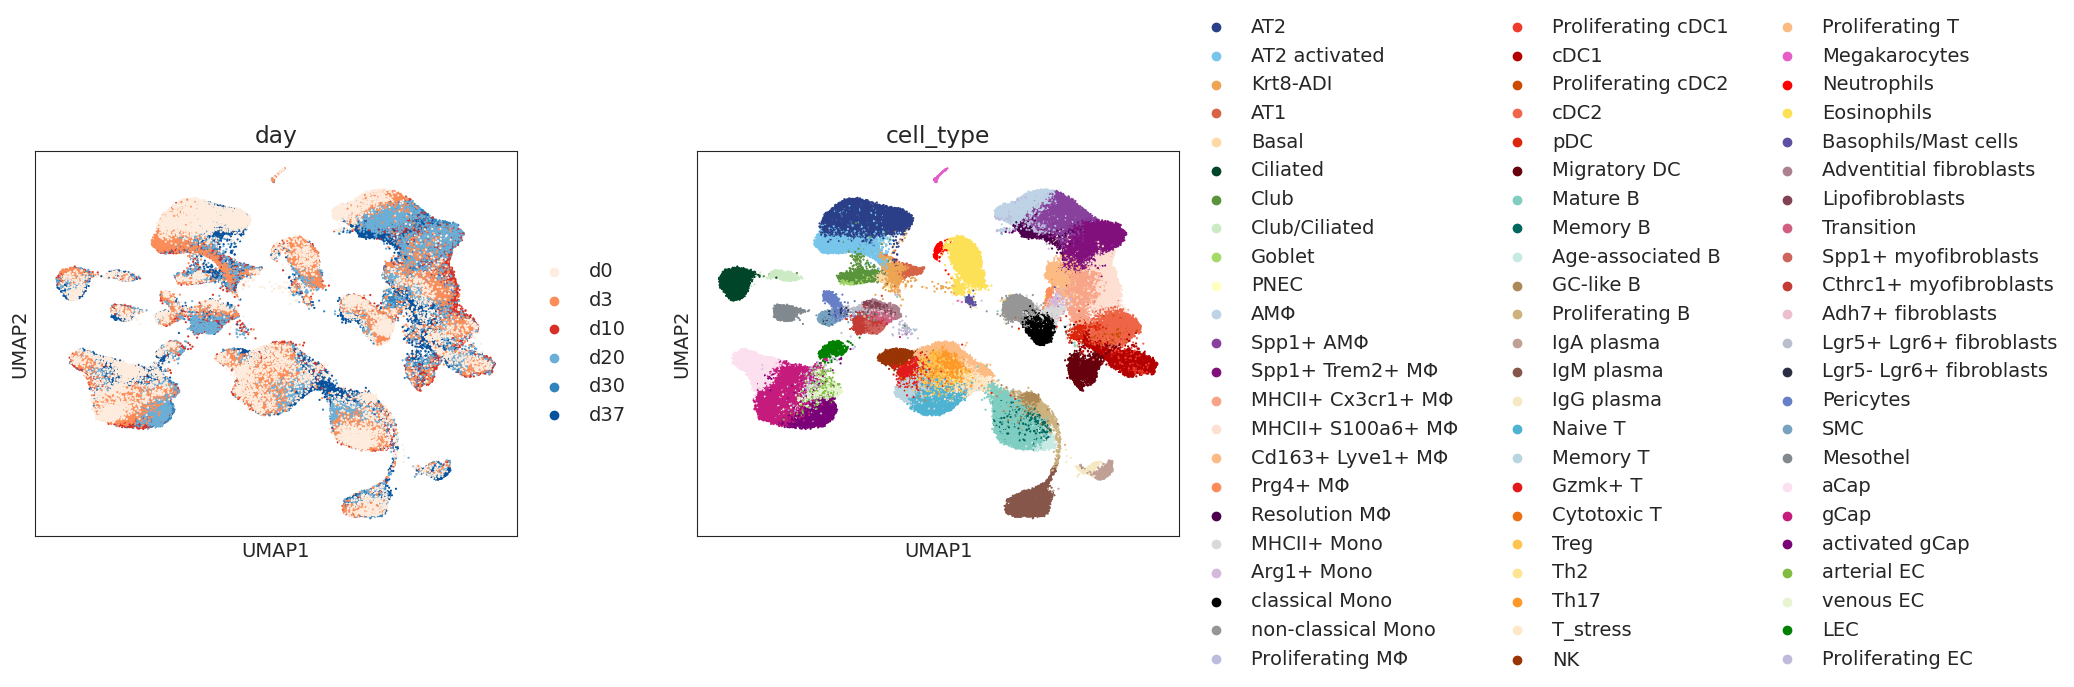

d37 - day
(16057, 3863)


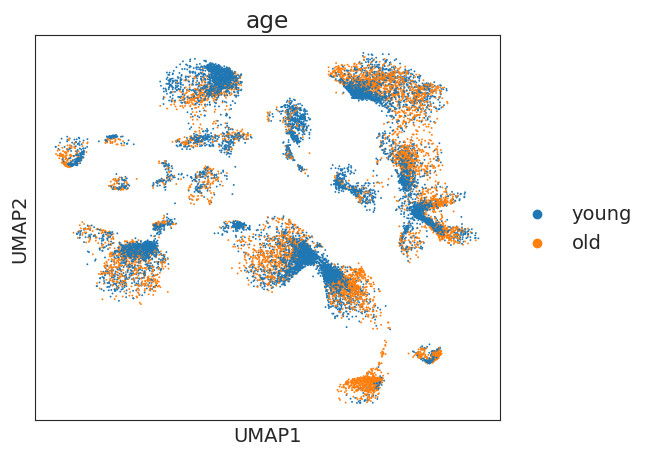

Started Diffxpy Calculation:	04-09-2024 13:19:46
training location model: True
training scale model: True
iter   0: ll=29096614.324231
iter   1: ll=27069278.710374, converged: 0.00% (loc: 0.00%, scale update: False), in 3.62sec
iter   2: ll=26561382.418088, converged: 0.00% (loc: 0.00%, scale update: False), in 3.54sec
iter   3: ll=26525775.962287, converged: 0.00% (loc: 0.00%, scale update: False), in 3.50sec
iter   4: ll=26525423.725075, converged: 0.00% (loc: 0.00%, scale update: False), in 3.68sec
iter   5: ll=26525422.756727, converged: 0.00% (loc: 1.58%, scale update: False), in 3.52sec
iter   6: ll=26200953.670945, converged: 0.00% (loc: 0.00%, scale update: True), in 69.62sec
iter   7: ll=26198485.991654, converged: 0.00% (loc: 0.03%, scale update: False), in 4.13sec
iter   8: ll=26198450.464869, converged: 0.00% (loc: 3.91%, scale update: False), in 4.10sec
iter   9: ll=26198450.035715, converged: 0.00% (loc: 18.53%, scale update: False), in 3.65sec
iter  10: ll=26198450.03007

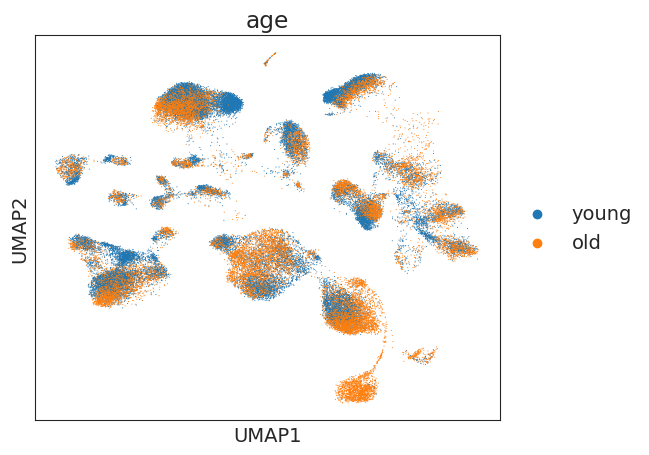

Started Diffxpy Calculation:	04-09-2024 13:25:16
training location model: True
training scale model: True
iter   0: ll=97734851.008422
iter   1: ll=90723534.097278, converged: 0.00% (loc: 0.00%, scale update: False), in 9.40sec
iter   2: ll=89111794.335353, converged: 0.00% (loc: 0.00%, scale update: False), in 9.47sec
iter   3: ll=89018015.759246, converged: 0.00% (loc: 0.00%, scale update: False), in 9.68sec
iter   4: ll=89017410.752225, converged: 0.00% (loc: 0.00%, scale update: False), in 9.38sec
iter   5: ll=89017409.900680, converged: 0.00% (loc: 10.72%, scale update: False), in 9.64sec
iter   6: ll=87977923.291240, converged: 0.00% (loc: 0.00%, scale update: True), in 230.68sec
iter   7: ll=87974228.532993, converged: 0.00% (loc: 0.08%, scale update: False), in 9.51sec
iter   8: ll=87974209.870650, converged: 0.00% (loc: 10.29%, scale update: False), in 9.58sec
iter   9: ll=87974209.796245, converged: 0.00% (loc: 39.43%, scale update: False), in 7.56sec
iter  10: ll=87974209.79

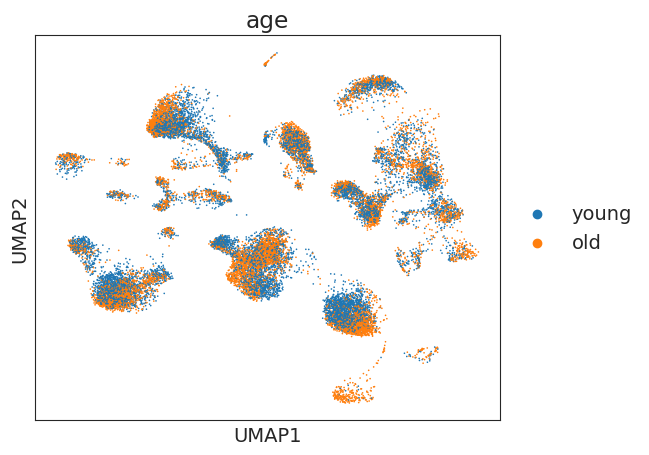

Started Diffxpy Calculation:	04-09-2024 13:42:18
training location model: True
training scale model: True
iter   0: ll=49159340.853394
iter   1: ll=45588406.378854, converged: 0.00% (loc: 0.00%, scale update: False), in 5.01sec
iter   2: ll=44701299.612693, converged: 0.00% (loc: 0.00%, scale update: False), in 4.89sec
iter   3: ll=44636713.180610, converged: 0.00% (loc: 0.00%, scale update: False), in 4.88sec
iter   4: ll=44635860.194652, converged: 0.00% (loc: 0.04%, scale update: False), in 5.00sec
iter   5: ll=44635855.716039, converged: 0.00% (loc: 4.71%, scale update: False), in 4.94sec
iter   6: ll=44104857.017548, converged: 0.00% (loc: 0.00%, scale update: True), in 108.77sec
iter   7: ll=44100271.315944, converged: 0.00% (loc: 0.09%, scale update: False), in 4.79sec
iter   8: ll=44100214.470739, converged: 0.00% (loc: 4.07%, scale update: False), in 4.81sec
iter   9: ll=44100213.901483, converged: 0.00% (loc: 22.31%, scale update: False), in 4.68sec
iter  10: ll=44100213.8953

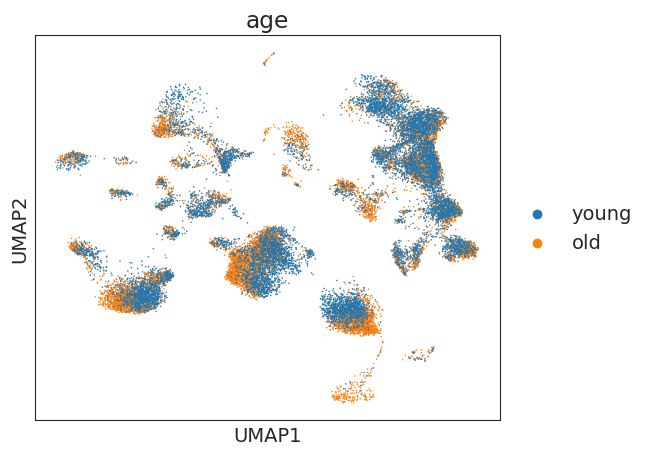

Started Diffxpy Calculation:	04-09-2024 13:50:58
training location model: True
training scale model: True
iter   0: ll=60717048.927705
iter   1: ll=55865811.248034, converged: 0.00% (loc: 0.00%, scale update: False), in 5.77sec
iter   2: ll=54644850.463412, converged: 0.00% (loc: 0.00%, scale update: False), in 5.89sec
iter   3: ll=54550641.238654, converged: 0.00% (loc: 0.00%, scale update: False), in 5.78sec
iter   4: ll=54549211.575349, converged: 0.00% (loc: 0.00%, scale update: False), in 6.09sec
iter   5: ll=54549202.803745, converged: 0.00% (loc: 2.22%, scale update: False), in 5.85sec
iter   6: ll=54006008.911924, converged: 0.00% (loc: 0.00%, scale update: True), in 128.37sec
iter   7: ll=53999135.221037, converged: 0.00% (loc: 0.08%, scale update: False), in 6.05sec
iter   8: ll=53999026.776557, converged: 0.00% (loc: 3.86%, scale update: False), in 5.71sec
iter   9: ll=53999025.405397, converged: 0.00% (loc: 17.61%, scale update: False), in 5.61sec
iter  10: ll=53999025.3875

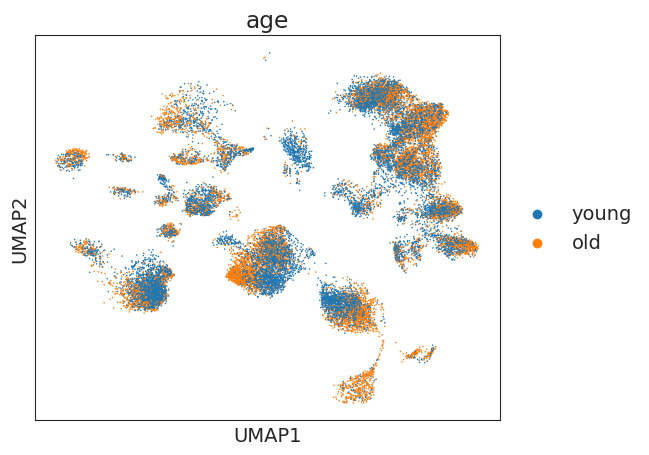

Started Diffxpy Calculation:	04-09-2024 14:01:55
training location model: True
training scale model: True
iter   0: ll=49469751.126151
iter   1: ll=45734104.885989, converged: 0.00% (loc: 0.00%, scale update: False), in 5.42sec
iter   2: ll=44804428.455348, converged: 0.00% (loc: 0.00%, scale update: False), in 5.43sec
iter   3: ll=44738179.147124, converged: 0.00% (loc: 0.00%, scale update: False), in 5.58sec
iter   4: ll=44737417.301928, converged: 0.00% (loc: 0.00%, scale update: False), in 5.58sec
iter   5: ll=44737414.335762, converged: 0.00% (loc: 4.05%, scale update: False), in 5.41sec
iter   6: ll=44046079.391287, converged: 0.00% (loc: 0.00%, scale update: True), in 104.04sec
iter   7: ll=44040350.539376, converged: 0.00% (loc: 0.05%, scale update: False), in 5.39sec
iter   8: ll=44040275.168398, converged: 0.00% (loc: 4.71%, scale update: False), in 5.43sec
iter   9: ll=44040274.359924, converged: 0.00% (loc: 19.29%, scale update: False), in 4.73sec
iter  10: ll=44040274.3506

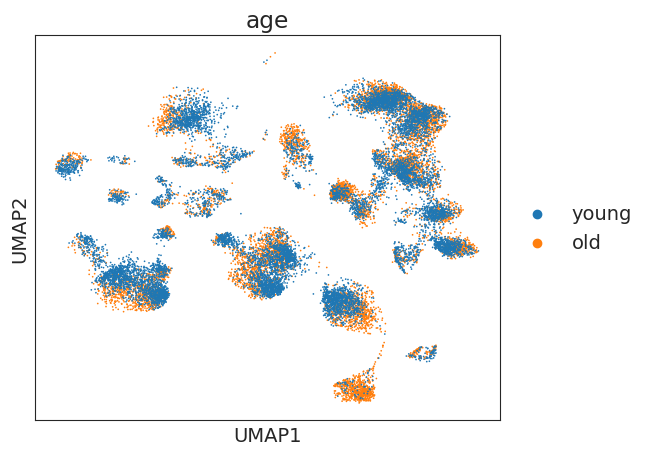

Started Diffxpy Calculation:	04-09-2024 14:10:42
training location model: True
training scale model: True
iter   0: ll=54526446.744168
iter   1: ll=50084663.651383, converged: 0.00% (loc: 0.00%, scale update: False), in 5.19sec
iter   2: ll=48904667.780645, converged: 0.00% (loc: 0.00%, scale update: False), in 5.12sec
iter   3: ll=48793888.665048, converged: 0.00% (loc: 0.00%, scale update: False), in 5.44sec
iter   4: ll=48790974.704949, converged: 0.00% (loc: 0.00%, scale update: False), in 5.42sec
iter   5: ll=48790935.510722, converged: 0.00% (loc: 0.88%, scale update: False), in 5.26sec
iter   6: ll=48602077.507155, converged: 0.00% (loc: 0.00%, scale update: True), in 105.99sec
iter   7: ll=48599588.901653, converged: 0.00% (loc: 0.14%, scale update: False), in 5.40sec
iter   8: ll=48599536.891569, converged: 0.00% (loc: 3.77%, scale update: False), in 5.10sec
iter   9: ll=48599535.880030, converged: 0.00% (loc: 20.06%, scale update: False), in 5.09sec
iter  10: ll=48599535.8595

In [18]:
out_folder = "/home/gotej/Projects/Aging_BleoModel/Data/DGE_pseudobulk/"

subset = ["young", "old"]
condition = "age"
ct_label = "day"
min_cells = 10

#time = "d0"
#time_subset = adata[adata.obs.day == time].copy()
sc.pl.umap(adata, color = ["day", "cell_type"], size = 10, wspace = 0.25)

for ct in days:
    
    print("%s - %s" %(ct, "day"))
    dge(adata, ct = ct, ct_label = ct_label, condition = condition, ref = "young", pct_thresh = 0.05,
        subset = subset, min_cells = min_cells, do_return = False, suffix = "")